# Multi-Fractal Detrended Fluctuation Analysis (MFDFA)
 
Multi-Fractal Detrended Fluctuation Analysis (MFDFA) which is an extension of Detrended Fluctuation Analysis (DFA) is one of the most widely used method to analyze fractality and long-range correlations in time series. I explined this method and each steps of its procedure in details [here](https://github.com/mohsenim/Multifractality). In this jupyter notebook, I show the code for each step and apply it to example time series, which are the sentence length of three texts:
* The Golden Bowl by Henry James
* The Puppet Crown by Harold MacGrath
* A Synopsis of the Birds of North America by John James Audubon

Let's first load the required libraries.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import r2_score, mean_squared_error
from numpy.lib.stride_tricks import as_strided
from numpy.polynomial.polynomial import polyval, polyfit


### 1) Bulilding the Profile of the Series

The profile of a series $X = x(1), x(2), \cdots, x(N)$ is the cumulative sum of the series centered around zero by subtracting the mean:    
$$Y(i) = \sum_{k=1}^{i} [x(k) - \langle X\rangle], i=1, \cdots, N$$
This step converts a time series into a random walk.

In [2]:
def compute_profile(X):
    '''
    Computes profile of X.
    '''

    return np.cumsum(X - np.mean(X))

Here, I load two the two examples and show the time series and their profile in a plot. 

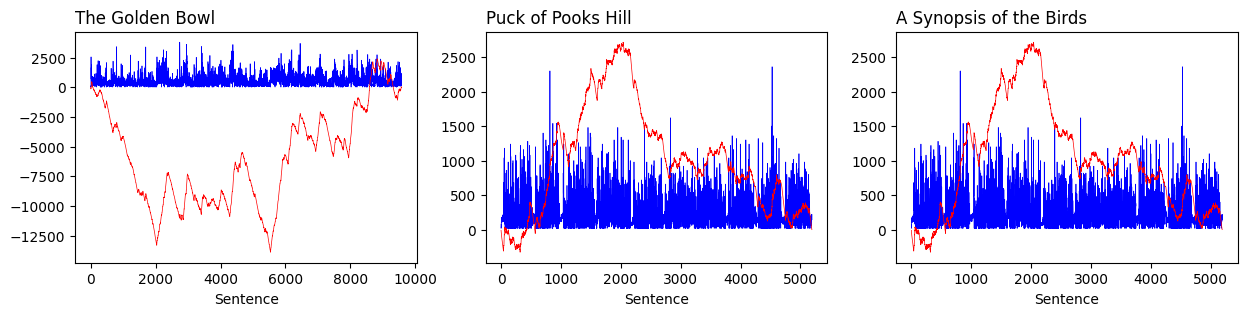

In [3]:

def plot_X(ax, X, X_profile, title=''):
    t = np.arange(len(X))
    ax.plot(20 * X, color='b', linewidth=0.5)  # multiplied by 10 to make the time series visible alongside the profile
    ax.plot(X_profile, color='r', linewidth=0.5)
    ax.set_xlabel('Sentence')
    ax.set_title(title, loc='left')


fig, axs = plt.subplots(1, 3, figsize=(15,3))

X1 = np.loadtxt('./examples/Henry-James_The-Golden-Bowl.txt')
X1_pofile = compute_profile(X1)
plot_X(axs[0], X1, X1_pofile, title='The Golden Bowl')

X2 = np.loadtxt('./examples/Rudyard-Kipling_Puck-of-Pooks-Hill.txt')
X2_pofile = compute_profile(X2)
plot_X(axs[1], X2, X2_pofile, title='Puck of Pooks Hill')

X3 = np.loadtxt('./examples/John-James-Audubon_A-Synopsis-of-the-Birds.txt')
X3_pofile = compute_profile(X3)
plot_X(axs[2], X2, X2_pofile, title='A Synopsis of the Birds')

plt.show()

### 2) Windowing
The second step of MFDFA is divining the profile of the series into $N_s=N/s$ windows for different values of $s$, which is the size of windows.

In [4]:
def windowing(X, s):
    '''
    Makes a sliding-window view of X.
    '''
    
    if not X.flags['C_CONTIGUOUS']:
        X = X.copy()
    return as_strided(X, (X.shape[0] // s, s), ((s * X.dtype.itemsize), X.dtype.itemsize))

### 3) Computation of  Mean Square Fluctuations in Each Window

Values in each window are detrended by subtracting the best fitting line.
As the length of the series, $N$, may not be always divisible by $s$, the window size, and a portion of the series in the end may be excluded from the computation, the windowing procedure is repeated starting from the end. As a result, the number of windows increases to $2 \times N_s$.
In the end, the mean square fluctuation of residuals are calculated in each window.

In [5]:
def bidir_mean_variance(X, scales, m=1):
    '''
    Computes the mean square fluctuation of residuals in sliding windows. Once from the beginning and once from the end.
    '''
    out = np.empty((len(scales), 2 * X.shape[0] // scales[0]))
    out[:] = np.nan
    X_inverse = X[::-1]
    for j, scale in enumerate(scales):
        idx = int((out.shape[1] // 2) - (X.shape[0] // scale))
        Y = np.concatenate((windowing(X, scale), windowing(X_inverse, scale)))
        i = np.arange(scale)
        coef = polyfit(i, Y.T, m)
        var = np.mean((Y - polyval(i, coef)) ** 2, axis=1)
        out[j, idx:idx + var.shape[0]] = var
    return out

### 4) Calculation of the $q$th order of the Mean Square Fluctuations

In [6]:
def compute_fluctuation_function(mv, qs):
    '''
    Compute scaling function F
    '''
    out = np.zeros((mv.shape[0], len(qs)), 'f8')
    mv = np.nan_to_num(mv)
    mask = mv < 0.0005  ## <0.0005 filters small values
    maskedMV = np.ma.array(mv, mask=mask, dtype=np.float64)
    for qi, q in enumerate(qs):
        if q == 0:
            continue
        out[:, qi] = (maskedMV ** (q / 2)).mean(1) ** (1.0 / q)
    out[:, qs == 0] = np.exp(0.5 * (np.ma.log(maskedMV)).mean(1))[:, None]
    return out


### 5) Computation of the Scaling Factor of Fluctuations
The groth factor of fluctuations, $h(q)$, is computed using a log-log regression on $F_q(s)$ values, i.e. $\log F_q(s)\sim h(q) \times \log s$.

The following method applies the above procedure to an input series. It also calculates the _degree of multifractality_ and _fractal asymmetry_ of the series.

In [7]:
def MFDFA_algorithm(series, scales, qs, polynomial_order=1):
    '''
    Applies MFDFA on a series
    '''
    profile = compute_profile(series)
    bmv = bidir_mean_variance(profile, scales, m=polynomial_order)
    Fq = compute_fluctuation_function(bmv, qs)
    Hq = np.zeros(len(qs))
    polynomial_coeff = np.zeros((len(qs), polynomial_order + 1))  # coefficients of fitted lines
    LSE = np.zeros(len(qs))  # least square error
    R2 = np.zeros(len(qs))  # R^2: goodness of fit
    for qi, q in enumerate(qs):
        try:
            mask = Fq[:, qi]==0
            mScales = np.ma.array(scales, mask=mask)
            mFq = np.ma.array(Fq[:, qi], mask=mask)
            coefs = np.ma.polyfit(np.ma.log2(mScales), np.ma.log2(mFq), 1)
            polynomial_coeff[qi] = coefs
            LSE[qi] = mean_squared_error(np.log2(mFq[mFq.mask==False]), np.polyval(coefs, np.log2(mScales[mScales.mask==False])))
            R2[qi] = r2_score(np.log2(mFq[mFq.mask==False]), np.polyval(coefs, np.log2(mScales[mScales.mask==False])))
            Hq[qi] = coefs[0]
        except:
            Hq[qi] = 0.5

    tq = Hq * qs - 1
    hq = np.diff(tq) / (qs[1] - qs[0])
    Dq = (qs[:-1] * hq) - tq[:-1]

    multifractal_dimension = max(hq) - min(hq)
    alfa0 = Hq[qs == 0][0]
    asymmetry = ((max(hq) - alfa0) - (alfa0 - min(hq))) / multifractal_dimension

    result = dict()
    result['series'] = series
    result['scales'] = scales
    result['qs'] = qs
    result['scaling_function'] = Fq
    result['h_q'] = Hq
    result['polynomial_coeff'] = polynomial_coeff
    result['H'] = result['h_q'][qs==2][0]
    result['tq'] = tq
    result['hq'] = hq
    result['Dq'] = Dq
    result['LSE'] = LSE
    result['R2'] = R2
    result['multifractality'] = multifractal_dimension
    result['asymmetry'] = asymmetry
    
    return result


For the above method, we should also provide scales, which is the list of window sizes, and qs, the range of $q$s. 

For my experiments, the window sizes are chosen as 16, 24, 32, etc., up to a point where the time series can still be divided into three non-overlapping windows. 
I also used a range of -5 to 5 with a step of 0.25 for $q$.

In [8]:
def get_scales(length):
    '''
    Returns the list of window sizes according to the length of the series. scales=16, 24, 32,...,(length/scale)>=3
    '''
    scales = []
    n = 6
    while 2 ** np.floor(n / 2.) + 2 ** np.floor((n + 1.) / 2.) < length / 3:
        scales.append(2 ** np.floor(n / 2.) + 2 ** np.floor((n + 1.) / 2.))
        n += 1
    scales = np.array(scales).astype('i4')
    return scales

Finally, the following method calls `MFDFA_algorithm` and apply MFDFA on a series.

In [9]:
def MFDFA(series):
    '''
    Returns three fractal metrics: degree of fractality, degree of multifractality, and asymmetry.
    MFDFA_algorithm returns more metrics and values. If you need them you should
    :param series:
    :return:
    '''
    scales = get_scales(series.size)
    qs = np.arange(-5.0, 5.01, 1.0 / 4)
    result = MFDFA_algorithm(series, scales, qs, 1)
    return result

## Visualization of Results for the Examples Series
First, I apply `MFDFA` on the series of the sentence lenght of the three texts.

In [11]:
X1_mfdfa_result = MFDFA(X1)
X2_mfdfa_result = MFDFA(X2)
X3_mfdfa_result = MFDFA(X3)

### Fractality

Now, I visualize the $q$th order of mean square fluctuations of the series for integer values of $q$. Inside each subplot, the _degree of fractality_ is shown a well.

The first text, _The Golden Bowl_, is highly fractal, as H is much greater than 0.5. 
_Puck of Pook Hill_ is fractal but less than the previous text. 
_A Synopsis of the Birds_, which is a non-fictional text, does not exhibit any fractality, as its H value is almost 0.5.

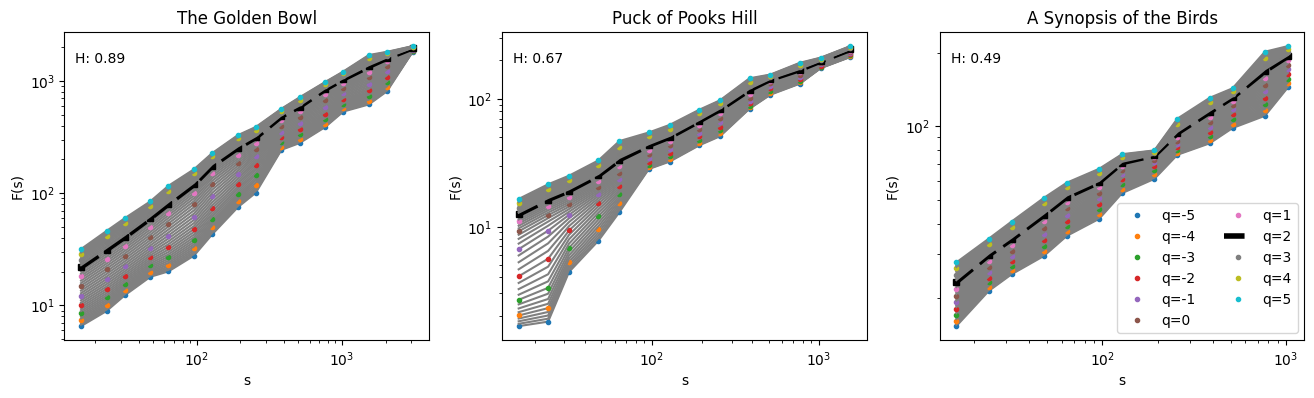

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
G = gridspec.GridSpec(1, 3)


def plot_fractality(ax, mfdfa_result, title=''):
    
    scales = mfdfa_result['scales']
    qs = mfdfa_result['qs']
    hs = []
    shown_qs = []
    for i, q in enumerate(qs):
        ax.loglog(scales, mfdfa_result['scaling_function'][:, i], '-', color='gray', markersize=2)
        if q % 1.0 != 0:
            continue
        coef_fitted_line = mfdfa_result['polynomial_coeff'][i]
        hs.append(coef_fitted_line[0])
        shown_qs.append(q)
        lbl = 'q={:.0f}'.format(q)
        if q == 2:
            ax.loglog(scales, mfdfa_result['scaling_function'][:, i], 's', color='black', markersize=5)
            ax.loglog(scales, mfdfa_result['scaling_function'][:, i], '--', color= 'black', linewidth=4, label=lbl)
        else:
            p = ax.loglog(scales, mfdfa_result['scaling_function'][:, i], 'o', markersize=3, label=lbl)

    ax.text(0.03, 0.9, f"H: {mfdfa_result['H']:.2f}", transform=ax.transAxes)
    ax.set_title(title)
    ax.set_xlabel('s')
    ax.set_ylabel('F(s)')
    
plot_fractality(axs[0], X1_mfdfa_result, title='The Golden Bowl')
plot_fractality(axs[1], X2_mfdfa_result, title='Puck of Pooks Hill')
plot_fractality(axs[2], X3_mfdfa_result, title='A Synopsis of the Birds')
axs[2].legend(ncol=2)


### Multifractality

In the plot below, the multifractility of the texts is represented. The multifractality spectrum of _The Golden Bowl_ and _Puck of Pooks Hill_ is wide, showing that these texts are multifractal. The difference between these texts is that the first one has a symmetrical fractal pattern, while the fractal pattern of the second text is highly asymmetrical. The multifractality spectrum of _A Synopsis of the Birds_ shows no evidence of fractality in this plot either.

For more information about $f(\alpha)$, look at the description of MFDFA [here](https://github.com/mohsenim/Multifractality).

<Figure size 640x480 with 0 Axes>

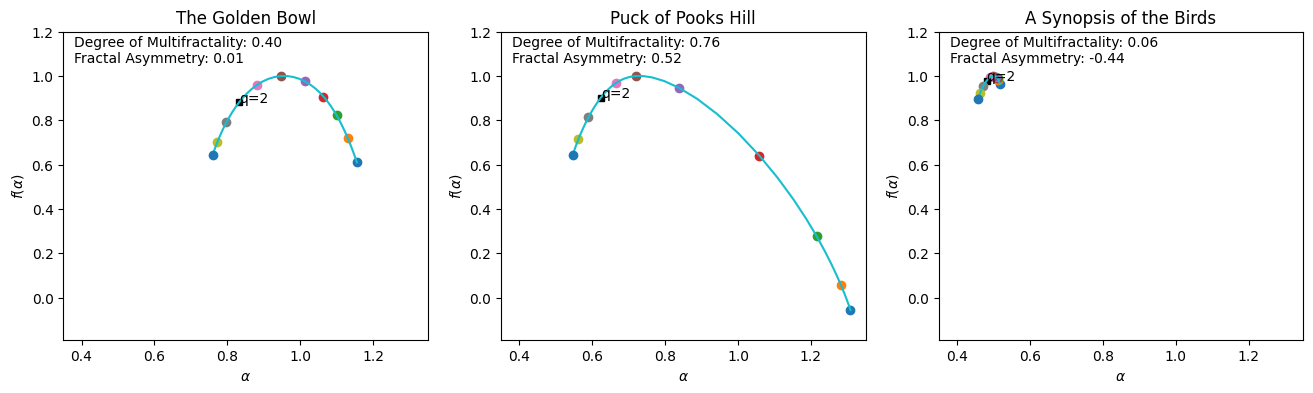

In [13]:
plt.figure()
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
G = gridspec.GridSpec(1, 3)


def plot_fractality(ax, mfdfa_result, title=''):
    
    scales = mfdfa_result['scales']
    qs = mfdfa_result['qs']
    hs = []
    shown_qs = []
    for i, q in enumerate(qs):
        if q % 1.0 != 0:
            continue
        coef_fitted_line = mfdfa_result['polynomial_coeff'][i]
        hs.append(coef_fitted_line[0])
        shown_qs.append(q)
        lbl = 'q={:.0f}'.format(q)
        if q == 2:
            ax.plot(mfdfa_result['hq'][i], mfdfa_result['Dq'][i], 's', color='black', markersize=5)
            ax.text(mfdfa_result['hq'][i], mfdfa_result['Dq'][i], 'q={:.0f}'.format(q), color='black', fontsize=10)
        else:
            if i < mfdfa_result['hq'].size:
                ax.plot(mfdfa_result['hq'][i], mfdfa_result['Dq'][i], 'o')

    ax.plot(mfdfa_result['hq'], mfdfa_result['Dq'], '-')
    ax.plot(mfdfa_result['hq'][-1], mfdfa_result['Dq'][-1], 'o')

    ax.text(0.03, 0.9, f"Degree of Multifractality: {mfdfa_result['multifractality']:.2f}\nFractal Asymmetry: {mfdfa_result['asymmetry']:.2f}", transform=ax.transAxes)
    ax.set_title(title)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$f(\alpha)$')
    ax.set_xlim(0.35,1.35)
    ax.set_ylim(-0.19,1.2)    
    
plot_fractality(axs[0], X1_mfdfa_result, title='The Golden Bowl')
plot_fractality(axs[1], X2_mfdfa_result, title='Puck of Pooks Hill')
plot_fractality(axs[2], X3_mfdfa_result, title='A Synopsis of the Birds')


### Goodness of Fit

The `MFDFA` method above also returns $R^2$ and Least Squared Error (LSE) for the fitted lines in Step 5 of the MFDFA procedure. These values can be used to analyze the found fractal patterns.

In [31]:
print(f"Mean R2 for The Golden Bowl: {X1_mfdfa_result['R2'].mean():.2f}")
print(f"Mean R2 for Puck of Pooks Hill: {X2_mfdfa_result['R2'].mean():.2f}")
print(f"Mean R2 for A Synopsis of the Birds: {X3_mfdfa_result['R2'].mean():.2f}")


Mean R2 for The Golden Bowl: 0.99
Mean R2 for Puck of Pooks Hill: 0.99
Mean R2 for A Synopsis of the Birds: 1.00
